<a href="https://colab.research.google.com/github/hafizhry/Pengenalan-Limfoma/blob/main/Pengenalan_Limfoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import package**

In [ ]:
# Import package yang diperlukan
import os
import pathlib
import glob

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from os import getcwd

**2. Persiapan data yang akan digunakan**

In [ ]:
# Import data
from google.colab import drive
drive.mount('/content/drive/')

%cd "/content/drive/.shortcut-targets-by-id/1w_btGZAxvZ4ODKQF0GWUDX_bKZrd_fB9/Paper Project/11-21_preprocessing"

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1w_btGZAxvZ4ODKQF0GWUDX_bKZrd_fB9/Paper Project/11-21_preprocessing


In [ ]:
# Penentuan directory data
#train_data_100_dir = '/data_enhanced/100x/train'
train_dir = 'data_enhanced/400x/train'
#test_data_100_dir = '/data_enhanced/100x/test'
test_dir = 'data_enhanced/400x/test'

train_data = pathlib.Path(train_dir)
test_data = pathlib.Path(test_dir)

train_BL_dir = os.path.join(train_dir, 'BL')
train_CA_dir = os.path.join(train_dir, 'CA')
train_LY_dir = os.path.join(train_dir, 'LY')

test_BL_dir = os.path.join(test_dir, 'BL')
test_CA_dir = os.path.join(test_dir, 'CA')
test_LY_dir = os.path.join(test_dir, 'LY')


In [ ]:
# Memperlihatkan jumlah data pada setiap kelas 
print('Jumlah kelas : ' + str(len(os.listdir(train_data))))
print('Jumlah data training')
print('BL : ' + str(len([name for name in os.listdir(train_BL_dir) if os.path.isfile(os.path.join(train_BL_dir, name))])))
print('CA : ' + str(len([name for name in os.listdir(train_CA_dir) if os.path.isfile(os.path.join(train_CA_dir, name))])))
print('LY : ' + str(len([name for name in os.listdir(train_LY_dir) if os.path.isfile(os.path.join(train_LY_dir, name))])))

print('Jumlah data training')
print('BL : ' + str(len([name for name in os.listdir(test_BL_dir) if os.path.isfile(os.path.join(test_BL_dir, name))])))
print('CA : ' + str(len([name for name in os.listdir(test_CA_dir) if os.path.isfile(os.path.join(train_CA_dir, name))])))
print('LY : ' + str(len([name for name in os.listdir(test_LY_dir) if os.path.isfile(os.path.join(test_LY_dir, name))])))

Jumlah kelas : 3
Jumlah data training
BL : 1094
CA : 893
LY : 1141
Jumlah data training
BL : 276
CA : 235
LY : 2629


In [ ]:
# Memperlihatkan jumlah data pada setiap kelas - nonaktif
print('Jumlah kelas : ' + str(len(os.listdir(train_data))))
print('Jumlah data training')
for kelas in os.listdir(train_dir):
  print(kelas + ' : ' + str(len([name for name in kelas if os.path.isfile(os.path.join(kelas, name))])))

print('Jumlah data test')
for kelas in os.listdir(test_dir):
  print(kelas + ' : ' + str(len([name for name in kelas if os.path.isfile(os.path.join(kelas, name))])))


Jumlah kelas : 3
Jumlah data training
LY : 0
CA : 0
BL : 0
Jumlah data test
BL : 0
LY : 0
CA : 0


In [ ]:
# Hyperparameter untuk data
img_height = 101
img_width = 101
target_size = (img_height,img_width)
batch_size = 16
class_mode = 'sparse'
jumlah_kelas = str(len(os.listdir(train_data)))


In [ ]:
# Menyiapkan data dengan melakukan augmentasi dan memasukkan ke generator
train_datagen = ImageDataGenerator(rescale=1.0/255,)
                                   #rotation_range = 90,
                                   
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    target_size = target_size)
validation_generator = train_datagen.flow_from_directory(test_dir,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    target_size = target_size)

Found 3128 images belonging to 3 classes.
Found 3150 images belonging to 3 classes.


**3. Persiapan model yang akan digunakan**

In [ ]:
# Import model transfer learning
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

pre_trained_model = InceptionResNetV2(weights = 'imagenet',
                                      include_top = False, 
                                      input_shape = (img_height, img_width, 3))

for layer in pre_trained_model.layers:
  layer.trainable = False 

pre_trained_model.summary()



Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 101, 101, 3) 0                                            
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 50, 50, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 50, 50, 32)   96          conv2d_205[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 50, 50, 32)   0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [ ]:
# Definisi model preprocessing - nonaktif
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
horizontal_random_flip_layer = layers.experimental.preprocessing.RandomFlip("horizontal")
vertical_random_flip_layer = layers.experimental.preprocessing.RandomFlip("vertical")
random_rotation_layer = layers.experimental.preprocessing.RandomRotation(0.1)
random_zoom_layer = layers.experimental.preprocessing.RandomZoom(0.1)

preprocessing_layers = [
    normalization_layer,
    horizontal_random_flip_layer,
    vertical_random_flip_layer,
    random_rotation_layer,
    random_zoom_layer,
]

In [ ]:
# Menggunakan preprocessing layer untuk data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.5),
])

In [ ]:
# Definisi model
models = [
         layers.GlobalAveragePooling2D(),
         layers.Flatten(),
         layers.Dense(128, activation='relu'),
         layers.Dropout(0.25),
         layers.Dense(64, activation='relu'),          
         layers.Dropout(0.25),
         layers.Dense(32, activation='relu'),
         layers.Dropout(0.25),
         layers.Dense(jumlah_kelas, activation='softmax')
]

In [ ]:
# Gabungan seluruh model - nonaktif
model = Sequential()
model.add(tf.keras.Input(shape= (img_height,img_width,3)))
#for layer in preprocessing_layers:
  #model.add(layer)
model.add(pre_trained_model)
for layer in data_augmentation:
  model.add(layer)
model.add(tf.keras.layers.Conv2D(2048, 1, activation = 'relu', input_shape = (5, 5, 2048)))
for layer in models:
  model.add(layer)

model.summary()

TypeError: ignored

In [ ]:
# Gabungan seluruh model 
model = tf.keras.Sequential([
                              pre_trained_model,
                              data_augmentation,
                              layers.Conv2D(2048, 1, activation = 'relu', input_shape = (5, 5, 2048)),
                              layers.GlobalAveragePooling2D(),
                              layers.Flatten(),
                              layers.Dense(128, activation='relu'),
                              layers.Dropout(0.25),
                              layers.Dense(64, activation='relu'),          
                              layers.Dropout(0.25),
                              layers.Dense(32, activation='relu'),
                              layers.Dropout(0.25),
                              layers.Dense(jumlah_kelas, activation='softmax')
                              ])



**4. Pelatihan Model**

In [ ]:
# Mengatur optimizer yang akan digunakan dan mengkompilasi model - nonaktif
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# Fungsi untuk mencari lr yang efisien
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 100))
optimizer = tf.keras.optimizers.RMSprop(lr=1e-8, momentum=0.9)

# Mengkompilasi model untuk mencari lr yang optimal
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['acc'])

In [ ]:
# Training untuk menemukan lr yang optimal
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    #steps_per_epoch = 100,
                    epochs = 50,
                    #validation_steps = 50,
                    #verbose = 2, 
                    callbacks = [lr_schedule])

Epoch 1/50
196/196 [==============================] - 34s 129ms/step - loss: 0.5868 - acc: 0.7779 - val_loss: 1.0241 - val_acc: 0.5190
Epoch 2/50
196/196 [==============================] - 23s 116ms/step - loss: 0.6128 - acc: 0.7603 - val_loss: 1.0280 - val_acc: 0.5181
Epoch 3/50
196/196 [==============================] - 22s 114ms/step - loss: 0.5998 - acc: 0.7709 - val_loss: 1.0317 - val_acc: 0.5149
Epoch 4/50
196/196 [==============================] - 23s 115ms/step - loss: 0.6048 - acc: 0.7597 - val_loss: 1.0331 - val_acc: 0.5140
Epoch 5/50
196/196 [==============================] - 23s 115ms/step - loss: 0.6212 - acc: 0.7579 - val_loss: 1.0362 - val_acc: 0.5117
Epoch 6/50
196/196 [==============================] - 22s 115ms/step - loss: 0.6024 - acc: 0.7639 - val_loss: 1.0401 - val_acc: 0.5108
Epoch 7/50
196/196 [==============================] - 23s 116ms/step - loss: 0.6381 - acc: 0.7551 - val_loss: 1.0376 - val_acc: 0.5111
Epoch 8/50
196/196 [==============================] - 2

(1e-08, 1e-05, 0.0, 1.0)

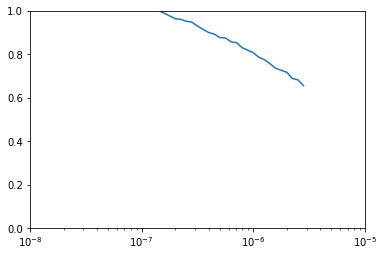

In [ ]:
# Plot nilai lr yang menghasilkan loss terkecil
lrs = 1e-8 * (10 ** (np.arange(50) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-5, 0, 1])

In [ ]:
# Mengatur lr yang optimal sesuai dengan training di atas
optimizer = tf.keras.optimizers.SGD(lr= 4e-4 , momentum=0.9)

# Mengkompilasi model untuk mencari lr yang optimal
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
              metrics = ['acc'])

In [ ]:
# Callback membatasi apabila training sudah mencapai akurasi maksimum
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'acc', patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath = 'model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only = True )
]


In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    #steps_per_epoch = 100,
                    epochs = 500,
                    #validation_steps = 50,
                    #verbose = 2, 
                    callbacks = my_callbacks)

Epoch 1/500
98/98 [==============================] - 49s 407ms/step - loss: 0.6546 - acc: 0.7192 - val_loss: 0.9044 - val_acc: 0.5286
Epoch 2/500
98/98 [==============================] - 37s 381ms/step - loss: 0.6767 - acc: 0.6940 - val_loss: 0.9303 - val_acc: 0.5079
Epoch 3/500
98/98 [==============================] - 37s 376ms/step - loss: 0.6642 - acc: 0.7097 - val_loss: 0.9499 - val_acc: 0.4921
Epoch 4/500
98/98 [==============================] - 37s 379ms/step - loss: 0.6310 - acc: 0.7259 - val_loss: 0.9046 - val_acc: 0.5270
Epoch 5/500
98/98 [==============================] - 37s 378ms/step - loss: 0.6560 - acc: 0.7108 - val_loss: 0.9422 - val_acc: 0.4956
Epoch 6/500
98/98 [==============================] - 37s 378ms/step - loss: 0.6599 - acc: 0.7126 - val_loss: 0.9229 - val_acc: 0.5092
Epoch 7/500
98/98 [==============================] - 37s 379ms/step - loss: 0.6377 - acc: 0.7185 - val_loss: 0.9530 - val_acc: 0.4860
Epoch 8/500
98/98 [==============================] - 37s 379ms

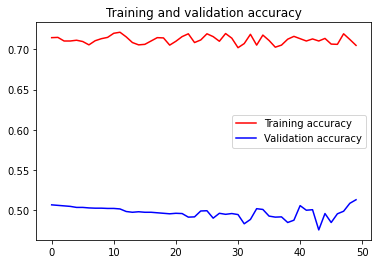

<Figure size 432x288 with 0 Axes>

In [ ]:
# Visualisasi hasil training model
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# F1 score dari training dan validasi